In [1]:
import itertools
import traceback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from numpy.linalg import LinAlgError
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox

In [2]:
river_df = pd.read_csv('stations/station_6335050_river_data.csv')
river_df.date = pd.to_datetime(river_df.date, format='%Y-%m-%d')
river_df = river_df.set_index('date')

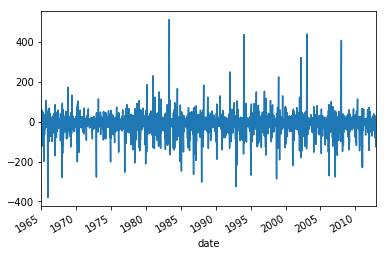

In [90]:
river_df.delta1.plot()

In [6]:
def predict_values(df, pred_start, pred_end):
    head_df = df[df.index < pred_start]
    train, val = train_test_split(head_df.water_level.values, test_size=0.2, 
                                                      shuffle=False)

    norm, lambd = boxcox(train)
    # print(f'Lambda: {lambd}')
    train = (train**lambd - 1)/lambd
    
    p = q = range(0, int(np.sqrt(train.shape[0])))
    d = range(0, 1)
    pdq = list(itertools.product(p, d, q))
    best_r2 = -np.inf
    best_params = pdq[0]
    best_arima = None
    
    for (p, d, q) in pdq:
        if p == 0 and d == 0 and q == 0: continue
        
        arima = ARIMA(train, (p, d, q))
        try:
            arima_fit = arima.fit()
        except LinAlgError as e:
            continue
        except ValueError as e:
            continue
            
        if d == 1:
            pred = arima_fit.forecast(len(val))[0]
        else:
            pred = arima_fit.forecast(len(val))[0]

        try:
            r2 = r2_score(val, pred)
        except ValueError as e:
            print(f'Flawed pred for {p}, {d}, {q}')
            traceback.print_exc()
            continue
            
        if r2 > best_r2:
            best_r2 = r2
            best_params = (p, d, q)
            best_arima = arima_fit
        
    print('Best r2:', best_r2)
    print('Best params:', best_params)
    norm, lambd = boxcox(head_df.water_level.values)
    # print(f'Lambda: {lambd}')
    
    arima = ARIMA(norm, best_params).fit()

    if best_params[1] == 1:
        pred_fin = arima.forecast(17)[0]
    else:
        pred_fin = best_arima.forecast(17)[0]
    
    pred_dates = pd.date_range(pred_start, pred_end).to_series().reset_index(drop=True)
    
    print(pred_dates.shape, len(pred_fin))
    
    def invboxcox(y):
          return ((y*lambd)+1)**(1/lambd)
    
    df.loc[pred_dates, 'water_level'] = invboxcox(pred_fin)
    

In [ ]:
full_range = pd.date_range(river_df.index.min(), river_df.index.max()+pd.Timedelta(days=1)) #TODO add last day!
river_df = river_df.reindex(full_range, fill_value=np.NaN)

next_gap = river_df.water_level.isnull().idxmax()
tail_gap = next_gap + pd.Timedelta(days=16)

while next_gap < pd.to_datetime('2013-01-01'):
    print(f'Working with gap {next_gap} - {tail_gap}.')
    predict_values(river_df, next_gap, tail_gap)
    river_df[river_df.index <= tail_gap].water_level.plot()
    
    next_gap = river_df.water_level.isnull().idxmax()
    tail_gap = next_gap + pd.Timedelta(days=16)

Working with gap 1965-04-17 00:00:00 - 1965-05-03 00:00:00.
Flawed pred for 6, 0, 3
Flawed pred for 7, 0, 5
Best r2: -14.392729505794172
Best params: (8, 0, 1)
(17,) 17
Working with gap 1965-08-01 00:00:00 - 1965-08-17 00:00:00.
Flawed pred for 4, 0, 2
Flawed pred for 4, 0, 3
Flawed pred for 5, 0, 3
Flawed pred for 6, 0, 4
Flawed pred for 7, 0, 6
Flawed pred for 8, 0, 3
Flawed pred for 8, 0, 5
Flawed pred for 8, 0, 6
Flawed pred for 9, 0, 5
Flawed pred for 9, 0, 6
Flawed pred for 9, 0, 7
Flawed pred for 9, 0, 8
Flawed pred for 9, 0, 9
Flawed pred for 10, 0, 3
Flawed pred for 10, 0, 4
Flawed pred for 10, 0, 7
Flawed pred for 10, 0, 9
Flawed pred for 10, 0, 10
Flawed pred for 11, 0, 4
Flawed pred for 11, 0, 5
Flawed pred for 11, 0, 7
Flawed pred for 11, 0, 10
Flawed pred for 12, 0, 4
Flawed pred for 12, 0, 6
Flawed pred for 12, 0, 11
Best r2: -0.642634810631086
Best params: (0, 0, 1)
(17,) 17
Working with gap 1965-11-15 00:00:00 - 1965-12-01 00:00:00.
Flawed pred for 4, 0, 2
Flawed pred 

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python3.7/site-packages/statsmodels/tsa/t

In [48]:
river_df[['water_level']].to_csv('station6335050_water_level.csv')

In [ ]:
river_df.head()

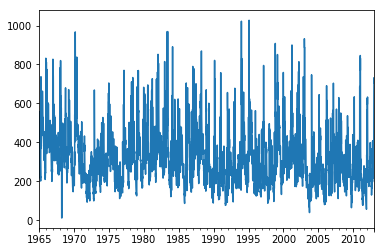

In [46]:
river_df.water_level.plot()